**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

4.943270921707153


In [4]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

In [5]:
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [6]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap30M = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

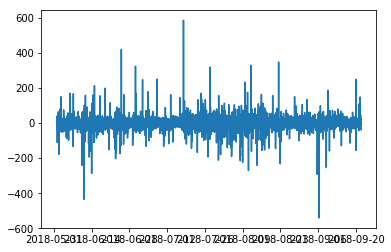

In [7]:
#30min的图
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

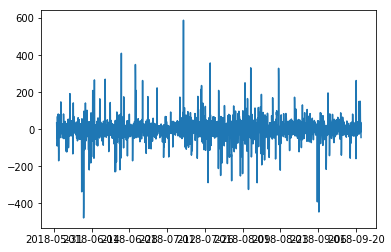

In [8]:
#1H的图
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

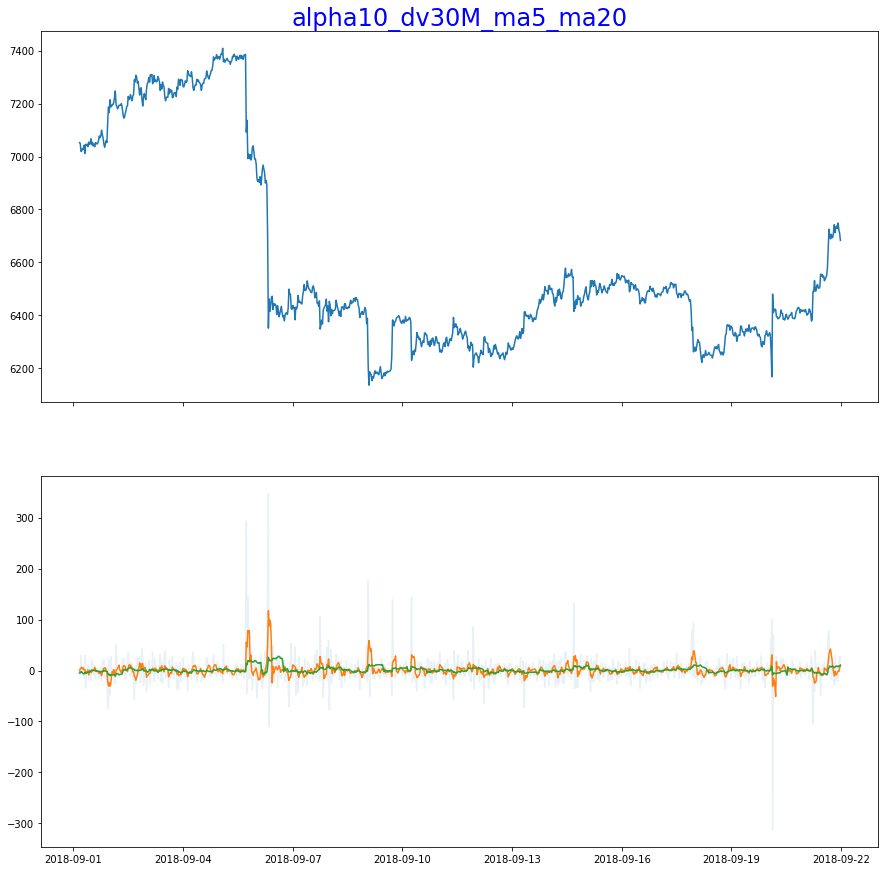

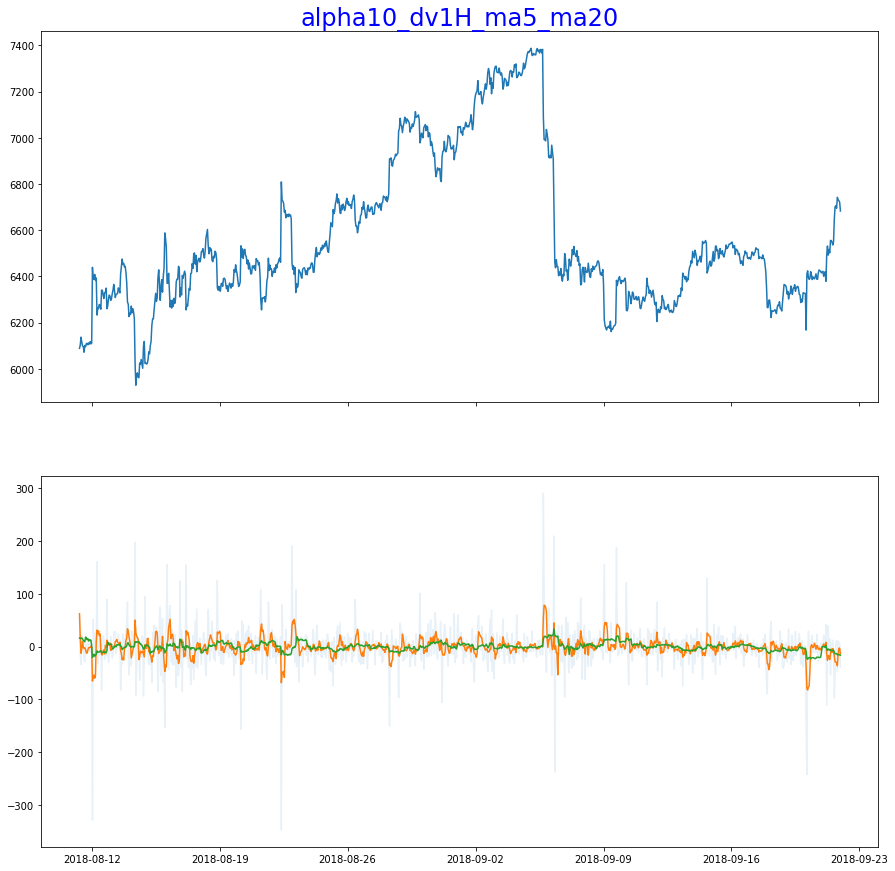

In [9]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    
    plt.savefig(chart_name)
    plt.show()
    
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}
import pandas as pd
#alpha10_dv30M是30分钟线，1H是1小时线，ma5和ma20代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线

In [10]:
long = dv1H.add_formula('longAlpha10','If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)',add_data = True)    
short = dv1H.add_formula('shortAlpha10','If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)',add_data = True)

close_long = dv1H.add_formula('closeLongAlpha10','If(shortAlpha10==-2,1,0)',add_data = True)
close_short = dv1H.add_formula('closeShortAlpha10','If(longAlpha10==2,-1,0)',add_data = True)

dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [14]:
from jaqs_fxdayu.research import TimingDigger
def TimingSignal(td, dv, long='long', short='short', closeLong='closeLong', closeShort='closeShort', mhp=None, sl=None, sp=None):
    
    td.process_signal(
        sig_type='long',
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        price=dv.get_ts('close'),
        max_holding_period=mhp,
        stoploss=-sl,
        stopprofit=sp
    )
    
    td.process_signal(
        sig_type='short',
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        price=dv.get_ts('close'),
        max_holding_period=mhp,
        stoploss=-sl,
        stopprofit=sp
    )

tdAlpha10 = TimingDigger(output_folder='.', output_format='pdf', signal_name='Alpha010')
TimingSignal(tdAlpha10, dv1H, 'longAlpha10', 'shortAlpha10', 'closeLongAlpha10', 'closeShortAlpha10', 100,0.05,0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [16]:
#(sig_type="long_short")
tdAlpha10.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [17]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

#打印出Morningstar事件的时间点
morningstar = dv1H.add_formula('morningstar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

4.3867199420928955
Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


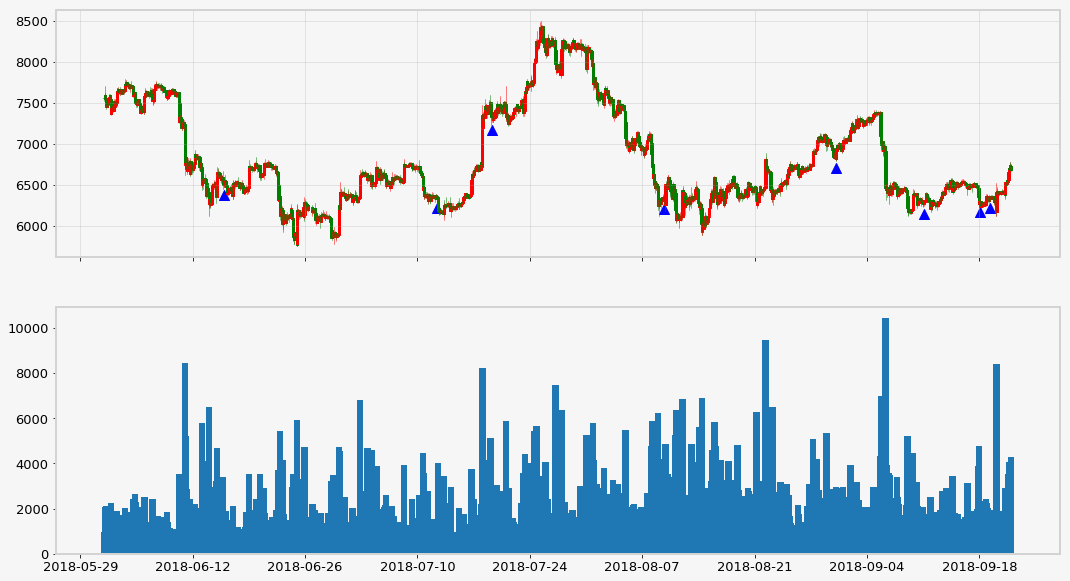

In [18]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

#定义绘图函数
def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

#画图
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index
morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [13]:
import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

path = r'./min_data/VnTrader_1Min_Db'
props = {'fields':'open,high,low,close,volume',
         'freq':'1H',
         'symbol':'BTCUSDT:binance',
         'start_date':20180801000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')

In [15]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [21]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [22]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

In [24]:
MorningdojiStar = dv1H.add_formula('morningdojistar', "If((Ta('CDLMORNINGDOJISTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)

In [25]:
MorningdojiStarVolume = dv1H.get_ts('morningdojistar', date_type='datetime')

In [26]:
MorningdojiStarVolume[MorningdojiStarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-08-09 17:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0


In [27]:
MorningdojiStarVolumeX = MorningdojiStarVolume[MorningStarVolume['BTCUSDT:binance']==100].index
MorningdojiStarVolumeY = data1H.loc[MorningdojiStarVolumeX].low-100

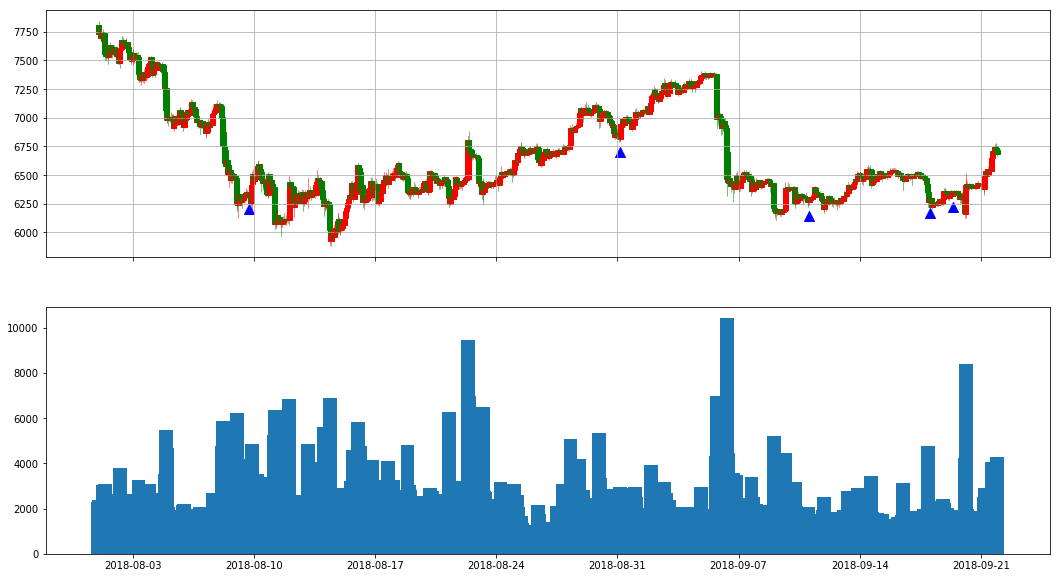

In [28]:
draw_candle(candle, MorningdojiStarVolumeX, MorningdojiStarVolumeY)

研究报告：
因子：Morning doji Star；

启明星在蜡烛图组合形态上标志着趋势反转，十字启明星更加体现多空双方的竞争胶着；
十字启明星出现后往往跟随其后的是放量上涨（或下跌）；

In [40]:
EMA5_J = dv1H.add_formula('EMA5_J', "Ta('EMA',0,0,0,0,close,0,5)",
                             add_data=True)

EMA20_J = dv1H.add_formula('EMA20_J', "Ta('EMA',0,0,0,0,close,0,20)",
                             add_data=True)

In [41]:
import matplotlib.pyplot as plt

def plot_chart(close,ma1,ma2):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(ma1.iloc[-1000:])
    ax1.plot(ma2.iloc[-1000:])
   
    plt.show()

In [43]:
ema5_plot = dv1H.get_ts('EMA5_J', date_type='datetime')
ema20_plot = dv1H.get_ts('EMA20_J', date_type='datetime')
close = dv1H.get_ts('close', date_type='datetime')

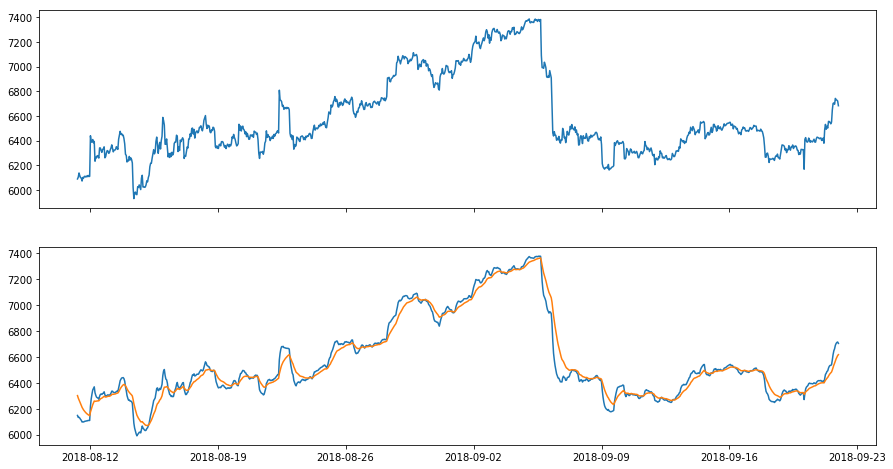

In [45]:
plot_chart(close, ema5_plot,ema20_plot)

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

十字启明星：

与成交量的联系：十字启明星出现后的几个交易日成交量会相比之前一段时间明显增加，但后市的行情并非一定是一路上扬，启明星的出现虽能作为趋势逆转的信号但也有一定风险。趋势性指标大多具有滞后性，在这个风格的信号设计上不考虑结合趋势性指标。

信号：十字启明星出现后直接多单进场，出场信号：价格最低价低于启明星最低价则出场

MACD:

与价格的联系： Hist由负变正，close由跌转涨。 Hist由正变负，close由涨转跌。 Hist的值为正时若出现向下趋势，上涨动能减小，下跌的可能性增大 Hist的值为负时若出现向上趋势，下跌动能减小，上涨的可能性增大 Hist柱线消失随时有可能出现涨跌转换 两条线数值位干0轴的下方时，说明目前的大势属干空头市场，应当以持币观望为主要策略
信号： 
(1)MACD与MACD_signal交叉信号 (2)MACD小于-30时，市场处于弱势；MACD大于30时，市场处于强势
进出场信号： 进场：在MACD线上叉MACD_signal且MACD大于-30时开多，下叉且MACD小于30时平多 出场：在MACD线下叉MACD_signal且MACD小于30时开空，上叉且MACD大于-30时平空

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [64]:
#选取因子
dv1H.add_formula('MACD', "Ta('EMA',0,0,0,0,close,0,12) - Ta('EMA',0,0,0,0,close,0,26)", add_data = True)
dv1H.add_formula('MACD_Signal', "Ta('EMA',0,0,0,0,MACD,0,9)", add_data = True)
dv1H.add_formula('Hist', "(MACD-MACD_Signal)", add_data = True)

symbol,BTCUSDT:binance
trade_date,
20180801000000,NaN
20180801010000,NaN
20180801020000,NaN
20180801030000,NaN
20180801040000,NaN
20180801050000,NaN
20180801060000,NaN
20180801070000,NaN
20180801080000,NaN


In [65]:
#设定进出场条件
long = dv1H.add_formula('longMACD','If((Hist>0) && (Delay(Hist,1)<=0) && (MACD>-70),2,0)',add_data = True)    
short = dv1H.add_formula('shortMACD','If((Hist<=0) && (Delay(Hist,1)>0) && (MACD<70),-2,0)',add_data = True)  
close_long = dv1H.add_formula('closeLongMACD','If(longMACD==-2,1,0)',add_data = True)
close_short = dv1H.add_formula('closeShortMACD','If(shortMACD==2,-1,0)',add_data = True)

In [66]:
#计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMACDStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaCDStatistic')

def TimingSignal(td, dv, long='long', short='short', closeLong='closeLong', closeShort='closeShort', mhp=None, sl=None, sp=None):
    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

MACD=dv1H.get_ts('MACD', date_type='datetime') 
MACD_Signal=dv1H.get_ts('MACD_Signal', date_type='datetime') 
Hist=dv1H.get_ts('Hist', date_type='datetime')
TimingSignal(tdMACDStatistic, dv1H, 'longMACD', 'shortMACD', 'closeLongMACD', 'closeShortMACD', mhp=100, sl=0.05, sp=0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%


In [67]:
tdMACDStatistic.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.439 -18.194  -0.312
p-value              0.000   0.000   0.756
mean                 0.049  -0.045  -0.002
std                  0.039   0.016   0.055
info_ratio           1.257  -2.841  -0.036
skewness             1.196   0.958   0.824
kurtosis             0.738   0.794  -0.023
pct5                 0.007  -0.065  -0.057
pct25                0.021  -0.055  -0.053
pct50                0.035  -0.052  -0.021
pct75                0.067  -0.035   0.033
pct95                0.120  -0.021   0.107
occurance           36.000  42.000  78.000
win_ratio              NaN     NaN   0.462
win_mean/loss_mean     NaN     NaN   1.073


In [68]:
tdMACDStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               9.656  -8.987  -0.812
p-value              0.000   0.000   0.422
mean                 0.035  -0.045  -0.006
std                  0.014   0.021   0.044
info_ratio           2.414  -2.180  -0.139
skewness            -0.290   0.748  -0.075
kurtosis             0.605  -0.179  -1.554
pct5                 0.008  -0.068  -0.065
pct25                0.031  -0.056  -0.053
pct50                0.035  -0.053  -0.001
pct75                0.044  -0.032   0.034
pct95                0.052  -0.002   0.048
occurance           17.000  18.000  35.000
win_ratio              NaN     NaN   0.486
win_mean/loss_mean     NaN     NaN   0.779


In [69]:
tdMACDStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.368 -19.292   0.144
p-value              0.000   0.000   0.886
mean                 0.061  -0.046   0.001
std                  0.048   0.011   0.063
info_ratio           1.265  -4.023   0.022
skewness             0.480   1.050   0.952
kurtosis            -1.038  -0.267  -0.294
pct5                 0.008  -0.056  -0.056
pct25                0.019  -0.055  -0.052
pct50                0.060  -0.052  -0.024
pct75                0.106  -0.040   0.028
pct95                0.140  -0.022   0.114
occurance           19.000  24.000  43.000
win_ratio              NaN     NaN   0.442
win_mean/loss_mean     NaN     NaN   1.332
